In [1]:
from langchain_community.document_loaders import DirectoryLoader

In [2]:
loader = DirectoryLoader('test-files', glob="**/*.txt")
docs = loader.load()

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=75,
    length_function=len,
    is_separator_regex=False,
)

In [5]:
docs = text_splitter.split_documents(docs)
texts = [doc.page_content for doc in docs]

In [6]:
import tiktoken

def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [7]:
counts = [num_tokens_from_string(t) for t in texts]

<function matplotlib.pyplot.show(close=None, block=None)>

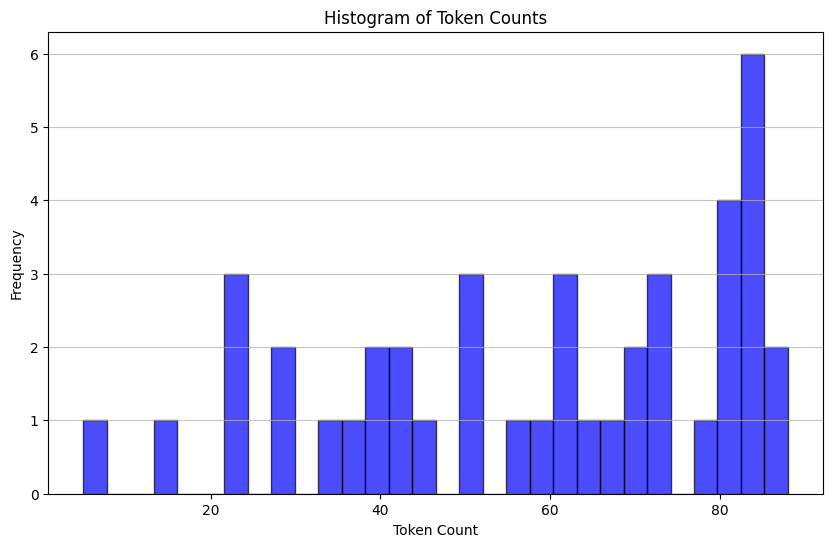

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show

In [9]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 2542


In [10]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

embedding_model = OpenAIEmbeddings()
model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

In [11]:
global_embeddings = [embedding_model.embed_query(txt) for txt in texts]

In [12]:
global_embeddings[0]

[0.005562269350491219,
 -0.009481367239129797,
 0.016060681309013104,
 -0.037103882294270335,
 -0.013238135144473388,
 0.013324269440330373,
 0.0023421825744824277,
 -0.019903582578891146,
 0.001760778056508168,
 -0.03082272461431137,
 -0.01046859520194241,
 0.010064428230645659,
 -0.0021434118030866233,
 0.00822911096024109,
 -0.010177065171845747,
 0.008116474019041003,
 0.01811464610199017,
 -0.035566723276435175,
 -0.00057809174551403,
 0.005529141276642975,
 -0.006890721316817931,
 0.0037468295297552433,
 -0.014311497403142985,
 -0.018551941147135168,
 -0.02719184636982322,
 0.02520413772454264,
 -0.0060923250513208755,
 -0.03164431313920529,
 0.009116953770186434,
 -0.008421255837470484,
 0.0204071356343777,
 -0.026502773865612412,
 -0.014324749191475803,
 -0.01905549420262172,
 -0.024740339102732007,
 -0.008739289444232785,
 0.0010071054124812069,
 -0.014377754482162008,
 0.0021400988560034188,
 -0.0022643307627487714,
 0.03670634168280126,
 0.01751833332214149,
 0.0022742691383

In [13]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]



/Users/mcevans/Programming/knowledge-vault-assistant/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


array([ 3.6454296, 10.230995 ], dtype=float32)

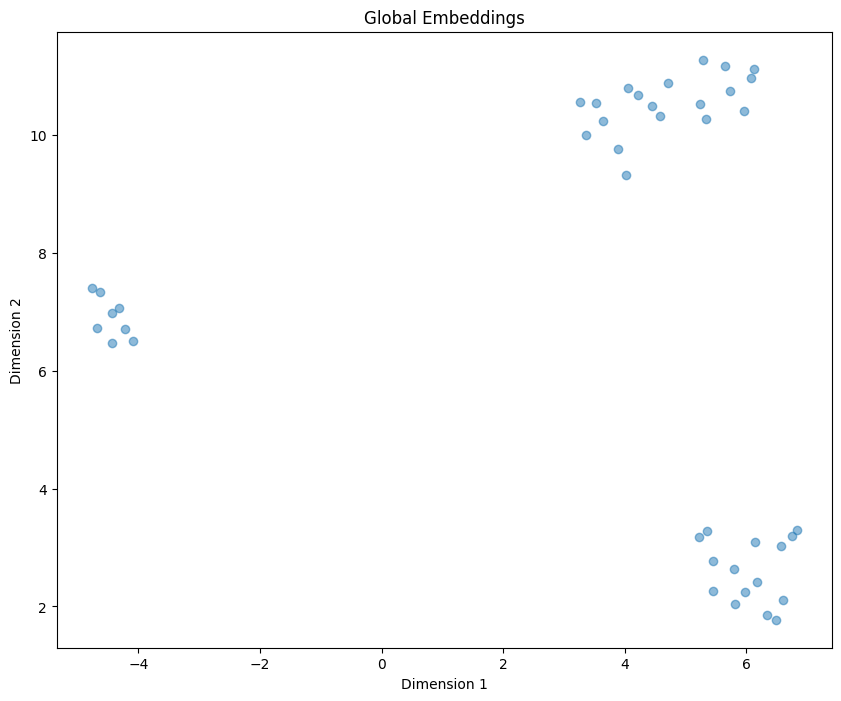

In [14]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 10, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

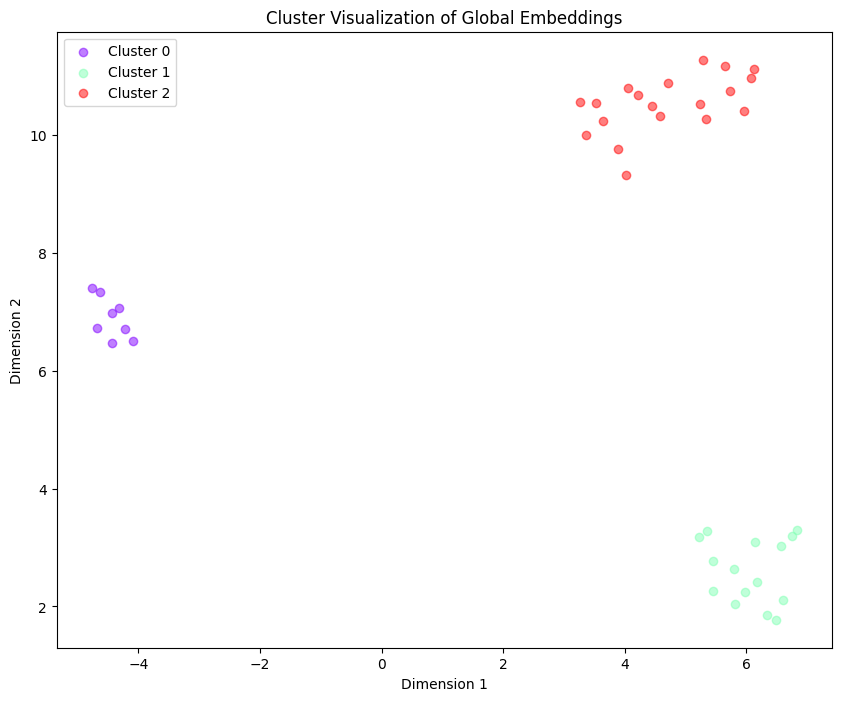

In [27]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [28]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
df.head(20)

,Text,Embedding,Cluster
0,Python's simplicity and extensive library supp...,"[3.6454296, 10.230995]",2
1,"In Scripting, Python excels due to its straigh...","[3.5364707, 10.532528]",2
2,"Moreover, Python is widely used in Testing. Fr...","[3.2612746, 10.547254]",2
3,"With its ease of use, comprehensive library ec...","[3.36475, 9.9893]",2
4,Python is a highly versatile and widely used p...,"[4.5836215, 10.324274]",2
5,One of the fundamental advanced techniques in ...,"[6.0811405, 10.967386]",2
6,of data that would otherwise occupy substantia...,"[6.1310964, 11.10968]",2
7,Another powerful feature in Python's advanced ...,"[5.6513014, 11.165284]",2
8,and measuring execution times. By using decora...,"[5.2859154, 11.2709465]",2
9,**Context Managers** are yet another advanced ...,"[5.95643, 10.396858]",2


In [29]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [30]:
clustered_texts = format_cluster_texts(df)

In [31]:
clustered_texts

{2: "Python's simplicity and extensive library support make it an excellent choice for automation across a variety of tasks, from simple scripts to complex automated systems. --- In Scripting, Python excels due to its straightforward syntax and readability, making it ideal for writing scripts that automate everyday tasks such as file management, system updates, or database operations. Web Scraping is another area where Python stands out. Libraries like BeautifulSoup and Scrapy simplify the process of extracting data from websites, automating what would otherwise be a tedious and error-prone task. --- Moreover, Python is widely used in Testing. Frameworks like Selenium and PyTest facilitate the automation of web and software testing processes. These tools help developers and QA engineers automate the testing of user interfaces and functionality, ensuring that applications perform as expected under various scenarios. --- With its ease of use, comprehensive library ecosystem, and supporti

In [35]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """You are an assistant to create a maximum 5 word summary of the text input prodived.
Text:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [36]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary


In [37]:
summaries

{2: 'Python: versatile, readable, powerful automation language.',
 1: 'UX research critical for user-centered design.',
 0: 'Machine learning trends and challenges.'}

In [38]:
embedded_summaries = [embedding_model.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [39]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [40]:
clustered_summaries

{0: ['Python: versatile, readable, powerful automation language.',
  'UX research critical for user-centered design.',
  'Machine learning trends and challenges.']}

In [41]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [42]:
final_summaries

{0: 'Python: versatile, readable, powerful automation.'}

In [ ]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [ ]:
from langchain_community.vectorstores import Chroma

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embedding_model)


In [ ]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("Give me a sweet recipe", 10000, 4)


In [ ]:
final_number

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [ ]:
from langchain_core.runnables import RunnablePassthrough

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
# Question
rag_chain.invoke("I'm looking for a baking recipe")